# Notebook 8 — Income DKL Choropleth Maps

Creates choropleth maps of `dkl_block` (block-group-level KL divergence) for
the four study cities using **geopandas** and a **contextily** basemap.

**`dkl_block`** aggregates the per-bin divergence over all income brackets for
each block group:
$$\text{DKL}_{\text{block}}(i) = \sum_j p_{yj|ni} \log_2\frac{p_{yj|ni}}{p_{yj}}$$

High values indicate block groups whose income distribution differs markedly
from the metro-area average.

**Inputs**:
- `data/acs5_block_2020_data/dkl_income_20_blkgrp_all_states.parquet`
- `data/shapefiles/usa_block_groups_2020.geojson`


In [1]:
# ── Imports ──────────────────────────────────────────────────────────────────
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.colors import Normalize
from matplotlib import cm

try:
    import contextily as ctx
    HAS_CONTEXTILY = True
except ImportError:
    HAS_CONTEXTILY = False
    print('[WARN] contextily not installed — basemaps will be omitted.\n'
          'Install with: pip install contextily')

warnings.filterwarnings('ignore')

NOTEBOOK_DIR = Path().resolve()
PIPELINE_DIR = NOTEBOOK_DIR.parent
if str(PIPELINE_DIR) not in sys.path:
    sys.path.insert(0, str(PIPELINE_DIR))

from config import DATA_DIR, CITIES

SHAPEFILE_PATH = DATA_DIR / 'shapefiles' / 'usa_block_groups_2020.geojson'
DKL_INCOME_2020 = DATA_DIR / 'acs5_block_2020_data' / 'dkl_income_20_blkgrp_all_states.parquet'

print(f'DATA_DIR         : {DATA_DIR}')
print(f'Shapefile path   : {SHAPEFILE_PATH}')
print(f'DKL income path  : {DKL_INCOME_2020}')
print(f'CITIES           : {CITIES}')


DATA_DIR         : /Users/bettencourt/Desktop/dkl-metric/pipeline/data
Shapefile path   : /Users/bettencourt/Desktop/dkl-metric/pipeline/data/shapefiles/usa_block_groups_2020.geojson
DKL income path  : /Users/bettencourt/Desktop/dkl-metric/pipeline/data/acs5_block_2020_data/dkl_income_20_blkgrp_all_states.parquet
CITIES           : ['Chicago-Naperville-Elgin, IL-IN-WI', 'Houston-The Woodlands-Sugar Land, TX', 'Atlanta-Sandy Springs-Alpharetta, GA', 'New York-Newark-Jersey City, NY-NJ-PA']


## 1. Load DKL Income Data (2020)


In [2]:
if not DKL_INCOME_2020.exists():
    raise FileNotFoundError(
        f'DKL income 2020 file not found:\n  {DKL_INCOME_2020}\n'
        'Run pipeline/2_calculate_dkl.py --years 2020 --vars income'
    )

dkl_raw = pd.read_parquet(DKL_INCOME_2020)
print(f'Loaded {len(dkl_raw):,} rows')
print(f'Columns: {list(dkl_raw.columns)}')

# Deduplicate to one row per block group (dkl_block is the same for all bins of
# the same block group within a variable_group)
BLOCK_FIPS_COL = 'block_fips'   # 12-digit GEOID
dkl_block = (
    dkl_raw[[
        BLOCK_FIPS_COL, 'cbsa_fips', 'cbsa_title', 'state_codes',
        'dkl_block', 'block_total'
    ]]
    .drop_duplicates(subset=[BLOCK_FIPS_COL])
    .copy()
)
print(f'Block-level rows (deduplicated): {len(dkl_block):,}')
dkl_block.head(3)


Loaded 3,550,928 rows
Columns: ['block_fips', 'county_fips', 'county_name', 'cbsa_fips', 'cbsa_title', 'area_type', 'central_outlying_county', 'state_codes', 'state_fips', 'state_name', 'variable', 'variable_group', 'variable_item', 'group_label', 'label', 'block_pct', 'block_estimate', 'moe', 'block_total', 'county_pct', 'county_estimate', 'county_total', 'cbsa_pct', 'cbsa_estimate', 'cbsa_total', 'p_ni', 'p_ni_yj', 'p_yj', 'p_yj_ni', 'dkl_log_i', 'dkl_log_j', 'dkl_block_j', 'dkl_bin_i', 'dkl_block', 'dkl_bin']
Block-level rows (deduplicated): 221,933


block_fips cbsa_fips      cbsa_title state_codes  dkl_block  block_total
0   010010201001     33860  Montgomery, AL          AL   0.593269          290
16  010010201002     33860  Montgomery, AL          AL   0.444888          403
32  010010202001     33860  Montgomery, AL          AL   0.421181          227

## 2. Load 2020 Block Group Shapefile


In [3]:
if not SHAPEFILE_PATH.exists():
    raise FileNotFoundError(
        f'Shapefile not found:\n  {SHAPEFILE_PATH}\n'
        'Run pipeline/5_shapefiles.py --years 2020'
    )

print(f'Reading shapefile: {SHAPEFILE_PATH.name}  (this may take a moment for all states) …')
bg_gdf = gpd.read_file(SHAPEFILE_PATH)
print(f'Loaded {len(bg_gdf):,} block groups')
print(f'CRS: {bg_gdf.crs}')
print(f'Columns: {list(bg_gdf.columns)}')
bg_gdf.head(3)


Reading shapefile: usa_block_groups_2020.geojson  (this may take a moment for all states) …


Loaded 233,803 block groups
CRS: EPSG:4326
Columns: ['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'AFFGEOID', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD', 'ALAND', 'AWATER', 'geometry']


STATEFP COUNTYFP TRACTCE BLKGRPCE               AFFGEOID         GEOID NAME  \
0      01      061  050100        3  1500000US010610501003  010610501003    3   
1      01      101  002600        2  1500000US011010026002  011010026002    2   
2      01      101  001600        2  1500000US011010016002  011010016002    2   

        NAMELSAD LSAD     ALAND  AWATER  \
0  Block Group 3   BG  12384479   26755   
1  Block Group 2   BG   1140196       0   
2  Block Group 2   BG   1056562       0   

                                            geometry  
0  POLYGON ((-86.08222 31.07949, -86.08029 31.088...  
1  POLYGON ((-86.24585 32.38357, -86.24565 32.387...  
2  POLYGON ((-86.28608 32.37217, -86.27436 32.372...

## 3. Join DKL Data to Geometry

Identify the GEOID column in the shapefile and merge on `block_fips`.


In [4]:
# Detect the GEOID column in the shapefile
GEOID_CANDIDATES = ['GEOID', 'GEOID10', 'GEOID20', 'geoid', 'GEO_ID', 'BGFIPS']
GEOID_COL = None
for col in GEOID_CANDIDATES:
    if col in bg_gdf.columns:
        GEOID_COL = col
        break
if GEOID_COL is None:
    raise KeyError(
        f'Could not find a GEOID column in the shapefile.\n'
        f'Available columns: {list(bg_gdf.columns)}'
    )
print(f'Using shapefile GEOID column: {GEOID_COL!r}')

# Normalise: ensure both keys are zero-padded 12-char strings
bg_gdf['_join_key']    = bg_gdf[GEOID_COL].astype(str).str.zfill(12)
dkl_block['_join_key'] = dkl_block[BLOCK_FIPS_COL].astype(str).str.zfill(12)

merged = bg_gdf.merge(dkl_block, on='_join_key', how='left')
print(f'After merge: {len(merged):,} features')
print(f'  With dkl_block data : {merged["dkl_block"].notna().sum():,}')
print(f'  Without (NaN)        : {merged["dkl_block"].isna().sum():,}')
merged.head(3)


Using shapefile GEOID column: 'GEOID'
After merge: 233,803 features
  With dkl_block data : 217,040
  Without (NaN)        : 16,763


STATEFP COUNTYFP TRACTCE BLKGRPCE               AFFGEOID         GEOID NAME  \
0      01      061  050100        3  1500000US010610501003  010610501003    3   
1      01      101  002600        2  1500000US011010026002  011010026002    2   
2      01      101  001600        2  1500000US011010016002  011010016002    2   

        NAMELSAD LSAD     ALAND  AWATER  \
0  Block Group 3   BG  12384479   26755   
1  Block Group 2   BG   1140196       0   
2  Block Group 2   BG   1056562       0   

                                            geometry     _join_key  \
0  POLYGON ((-86.08222 31.07949, -86.08029 31.088...  010610501003   
1  POLYGON ((-86.24585 32.38357, -86.24565 32.387...  011010026002   
2  POLYGON ((-86.28608 32.37217, -86.27436 32.372...  011010016002   

     block_fips cbsa_fips      cbsa_title state_codes  dkl_block  block_total  
0  010610501003     20020      Dothan, AL          AL   0.290570        512.0  
1  011010026002     33860  Montgomery, AL          AL   0.729941        405.0  
2  011010016002     33860  Montgomery, AL          AL   0.497558        334.0

## 4. Define City Clip Extents

For each study city, subset the merged GeoDataFrame to block groups whose
`cbsa_title` matches the city.  We use the bounding box (total_bounds) of those
block groups as the map extent and add a small buffer for context.


In [5]:
CITY_SHORT = {
    c: c.split(',')[0].split('-')[0].strip() for c in CITIES
}


def get_city_gdf(merged_gdf: gpd.GeoDataFrame, city_full: str) -> gpd.GeoDataFrame:
    """
    Return the subset of block groups for a city, reprojected to EPSG:3857
    (Web Mercator, required by contextily).
    """
    primary = city_full.split(',')[0]
    mask = merged_gdf['cbsa_title'].str.contains(primary, case=False, na=False)
    sub = merged_gdf[mask].copy()
    if sub.empty:
        print(f'  [WARN] No block groups matched for: {primary!r}')
    else:
        print(f'  {primary}: {len(sub):,} block groups')

    # Reproject to Web Mercator for contextily compatibility
    if sub.crs is None:
        sub = sub.set_crs('EPSG:4326')
    sub = sub.to_crs('EPSG:3857')
    return sub


print('Block groups per city:')
city_gdfs = {}
for city in CITIES:
    city_gdfs[city] = get_city_gdf(merged, city)


Block groups per city:
  Chicago-Naperville-Elgin: 6,861 block groups
  Houston-The Woodlands-Sugar Land: 4,151 block groups


  Atlanta-Sandy Springs-Alpharetta: 3,942 block groups
  New York-Newark-Jersey City: 14,880 block groups


## 5. Choropleth Maps with Contextily Basemap

For each city:
1. Plot block groups coloured by `dkl_block` using a perceptually uniform
   colormap (Viridis).
2. Add a contextily basemap (CartoDB Positron — light, unobtrusive).
3. Add a colourbar, north arrow annotation, and title.


In [6]:
def compute_global_vmin_vmax(city_gdfs: dict) -> tuple:
    """
    Use a shared colour scale across all city maps (99th-percentile cap)
    to make cross-city comparisons valid.
    """
    all_vals = pd.concat(
        [g['dkl_block'].dropna() for g in city_gdfs.values()]
    )
    vmin = 0.0
    vmax = float(np.percentile(all_vals, 99)) if len(all_vals) else 1.0
    return vmin, vmax


VMIN, VMAX = compute_global_vmin_vmax(city_gdfs)
print(f'Shared colour scale: vmin={VMIN:.4f}, vmax={VMAX:.4f} (99th pctile cap)')


Shared colour scale: vmin=0.0000, vmax=2.3693 (99th pctile cap)


Plotting: Chicago …


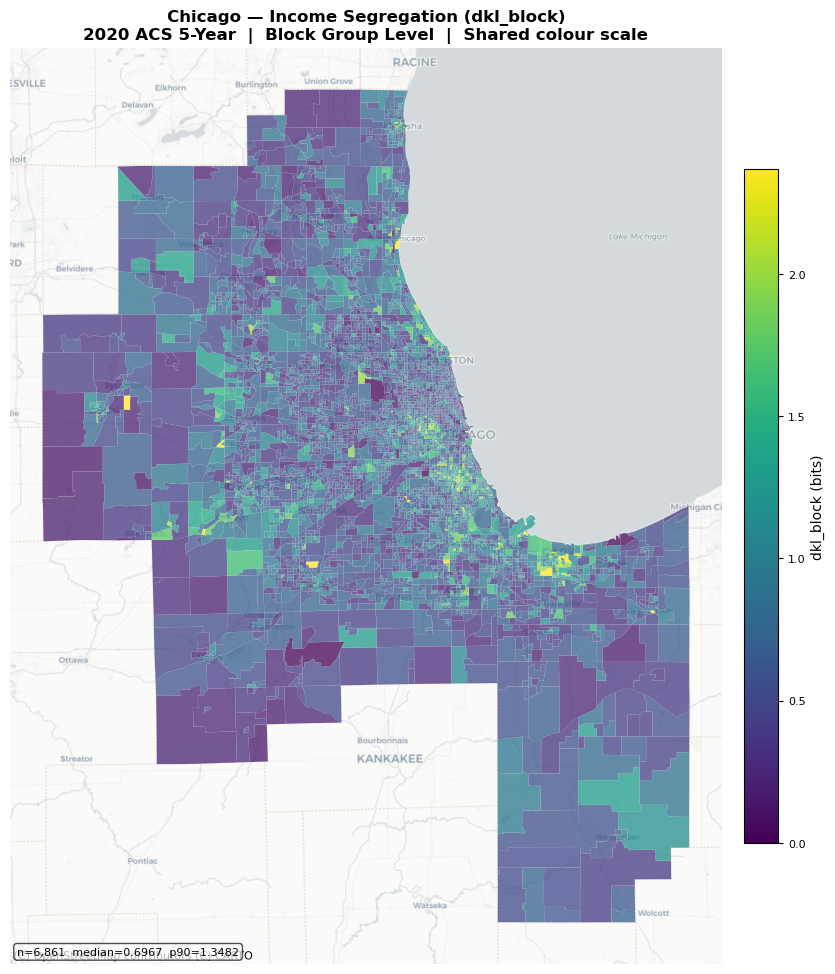

Plotting: Houston …


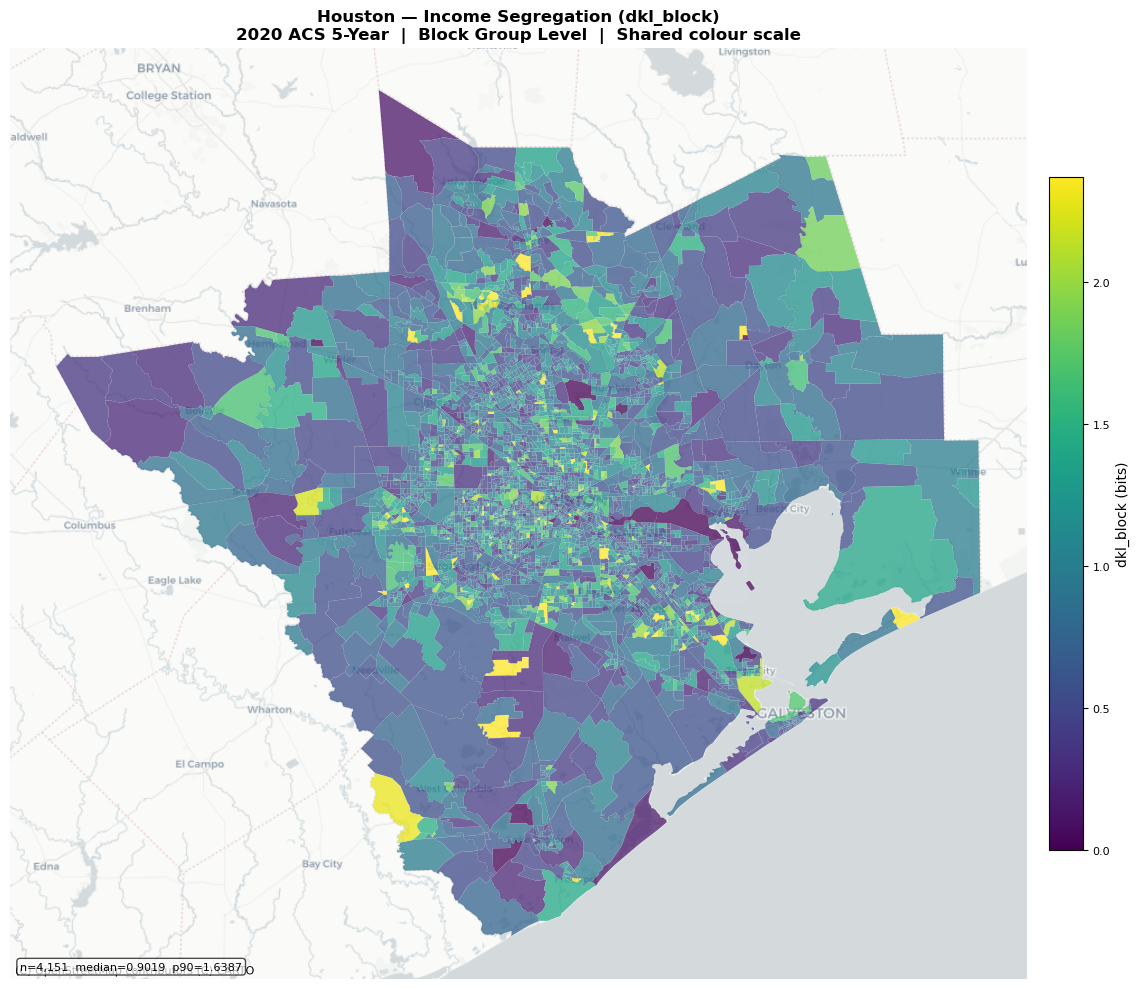

Plotting: Atlanta …


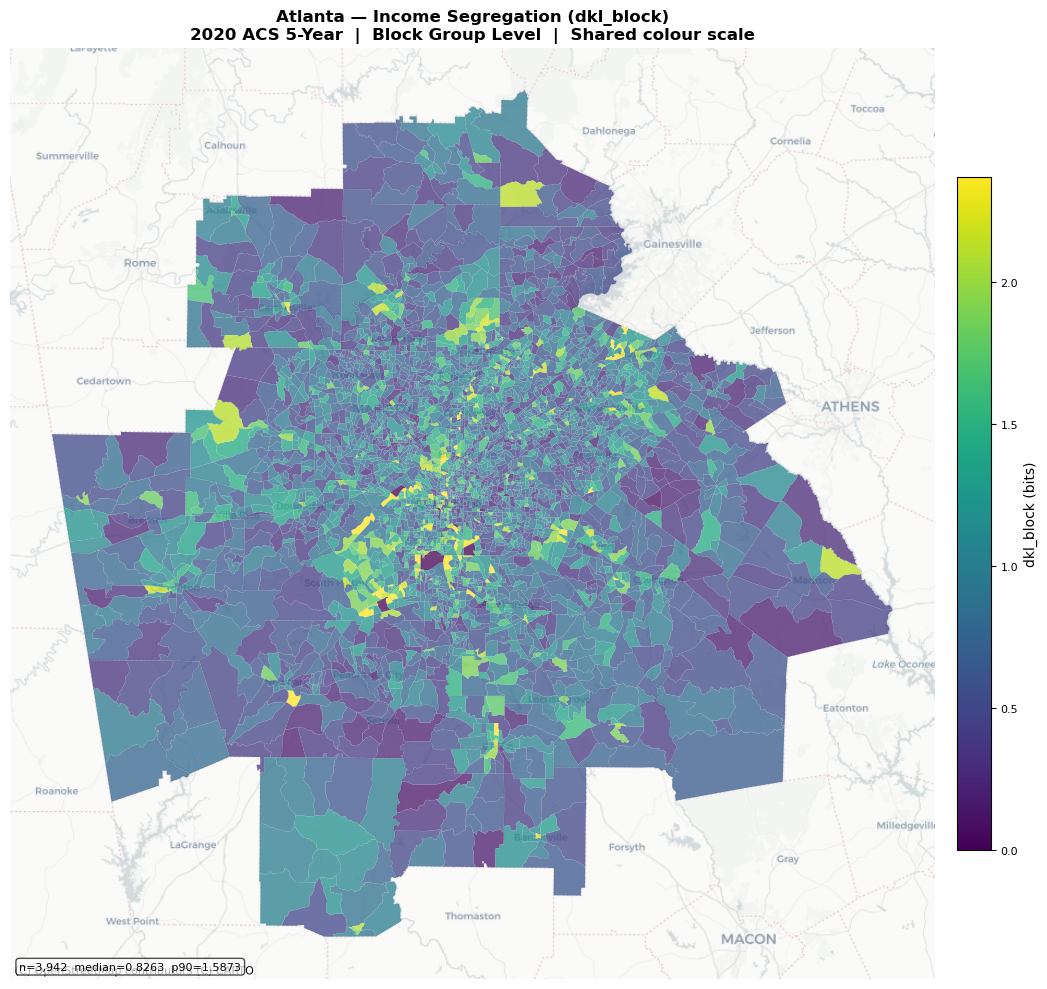

Plotting: New York …


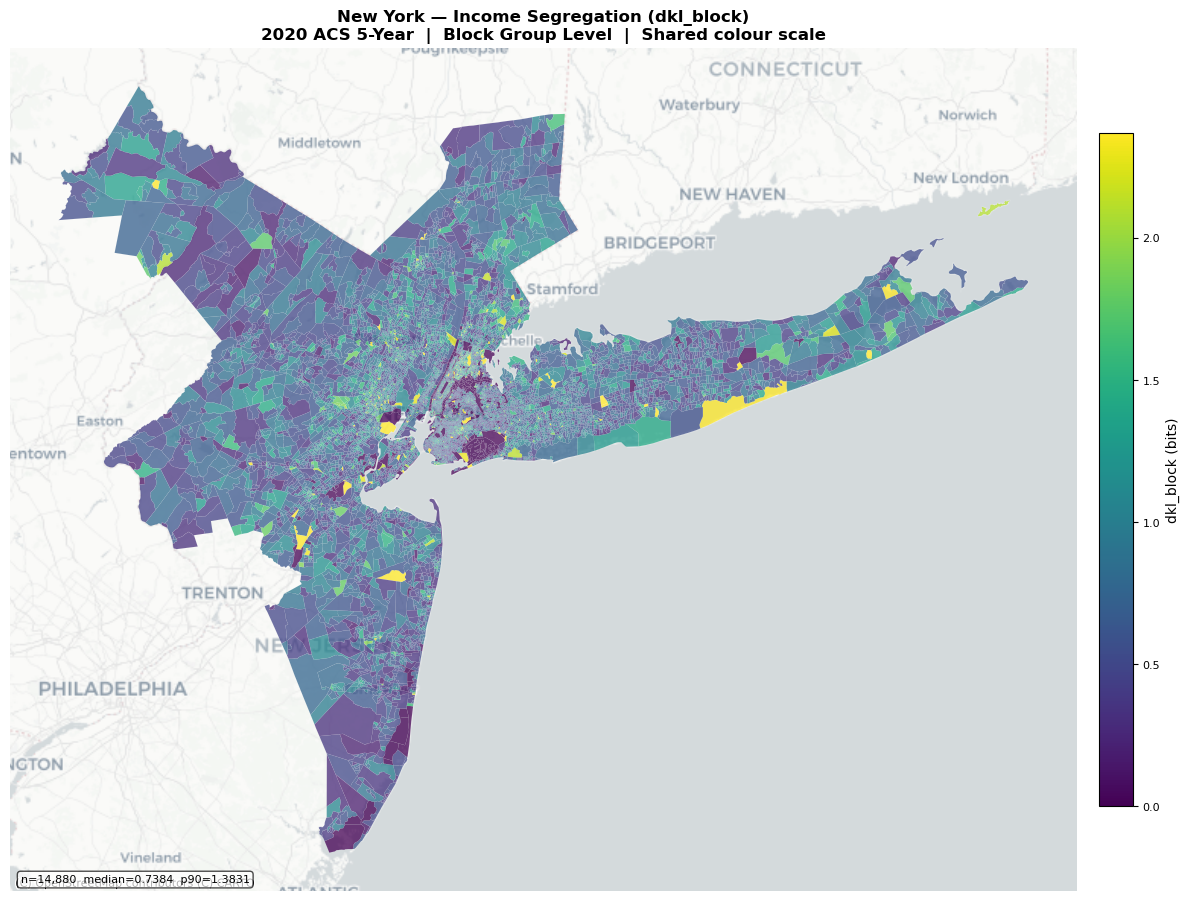

In [7]:
def plot_choropleth(city_gdf: gpd.GeoDataFrame, city_label: str,
                    vmin: float, vmax: float,
                    cmap: str = 'viridis',
                    figsize: tuple = (12, 10),
                    add_basemap: bool = True,
                    alpha: float = 0.75) -> None:
    """
    Plot a choropleth of dkl_block for a single city with an optional
    contextily basemap.

    Parameters
    ----------
    city_gdf    : GeoDataFrame in EPSG:3857
    city_label  : display name for the title
    vmin, vmax  : colour scale bounds
    cmap        : matplotlib colormap name
    figsize     : figure size in inches
    add_basemap : whether to overlay a contextily basemap
    alpha       : fill transparency for block group polygons
    """
    if city_gdf.empty:
        print(f'Skipping {city_label!r} — no data.')
        return

    fig, ax = plt.subplots(figsize=figsize)

    # --- Draw block groups: missing data in light grey ---
    missing = city_gdf[city_gdf['dkl_block'].isna()]
    if not missing.empty:
        missing.plot(ax=ax, color='#d9d9d9', linewidth=0, alpha=0.5, zorder=1)

    present = city_gdf[city_gdf['dkl_block'].notna()]
    if present.empty:
        ax.set_title(f'{city_label} — no dkl_block data')
        plt.show()
        return

    present.plot(
        column='dkl_block',
        ax=ax,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        linewidth=0.05, edgecolor='white',
        alpha=alpha,
        legend=False,
        zorder=2
    )

    # --- Contextily basemap ---
    if add_basemap and HAS_CONTEXTILY:
        try:
            ctx.add_basemap(
                ax,
                source=ctx.providers.CartoDB.Positron,
                zoom='auto',
                zorder=0
            )
        except Exception as exc:
            print(f'  [WARN] Basemap failed for {city_label}: {exc}')

    # --- Colourbar ---
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm   = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label('dkl_block (bits)', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # --- Titles and axes ---
    ax.set_title(
        f'{city_label} — Income Segregation (dkl_block)\n'
        f'2020 ACS 5-Year  |  Block Group Level  |  Shared colour scale',
        fontsize=12, fontweight='bold'
    )
    ax.set_axis_off()

    # --- Stats annotation ---
    vals = present['dkl_block']
    stats_text = (
        f'n={len(vals):,}  '
        f'median={vals.median():.4f}  '
        f'p90={vals.quantile(0.9):.4f}'
    )
    ax.annotate(
        stats_text,
        xy=(0.01, 0.01), xycoords='axes fraction',
        fontsize=8, color='black',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
    )

    plt.tight_layout()
    plt.show()


# ── Render all four cities ────────────────────────────────────────────────────
for city_full in CITIES:
    label = CITY_SHORT[city_full]
    print(f'Plotting: {label} …')
    plot_choropleth(city_gdfs[city_full], label, VMIN, VMAX)


## 6. Side-by-Side Four-City Map Panel

Display all four city maps on a single 2×2 figure grid for publication-ready
comparison.


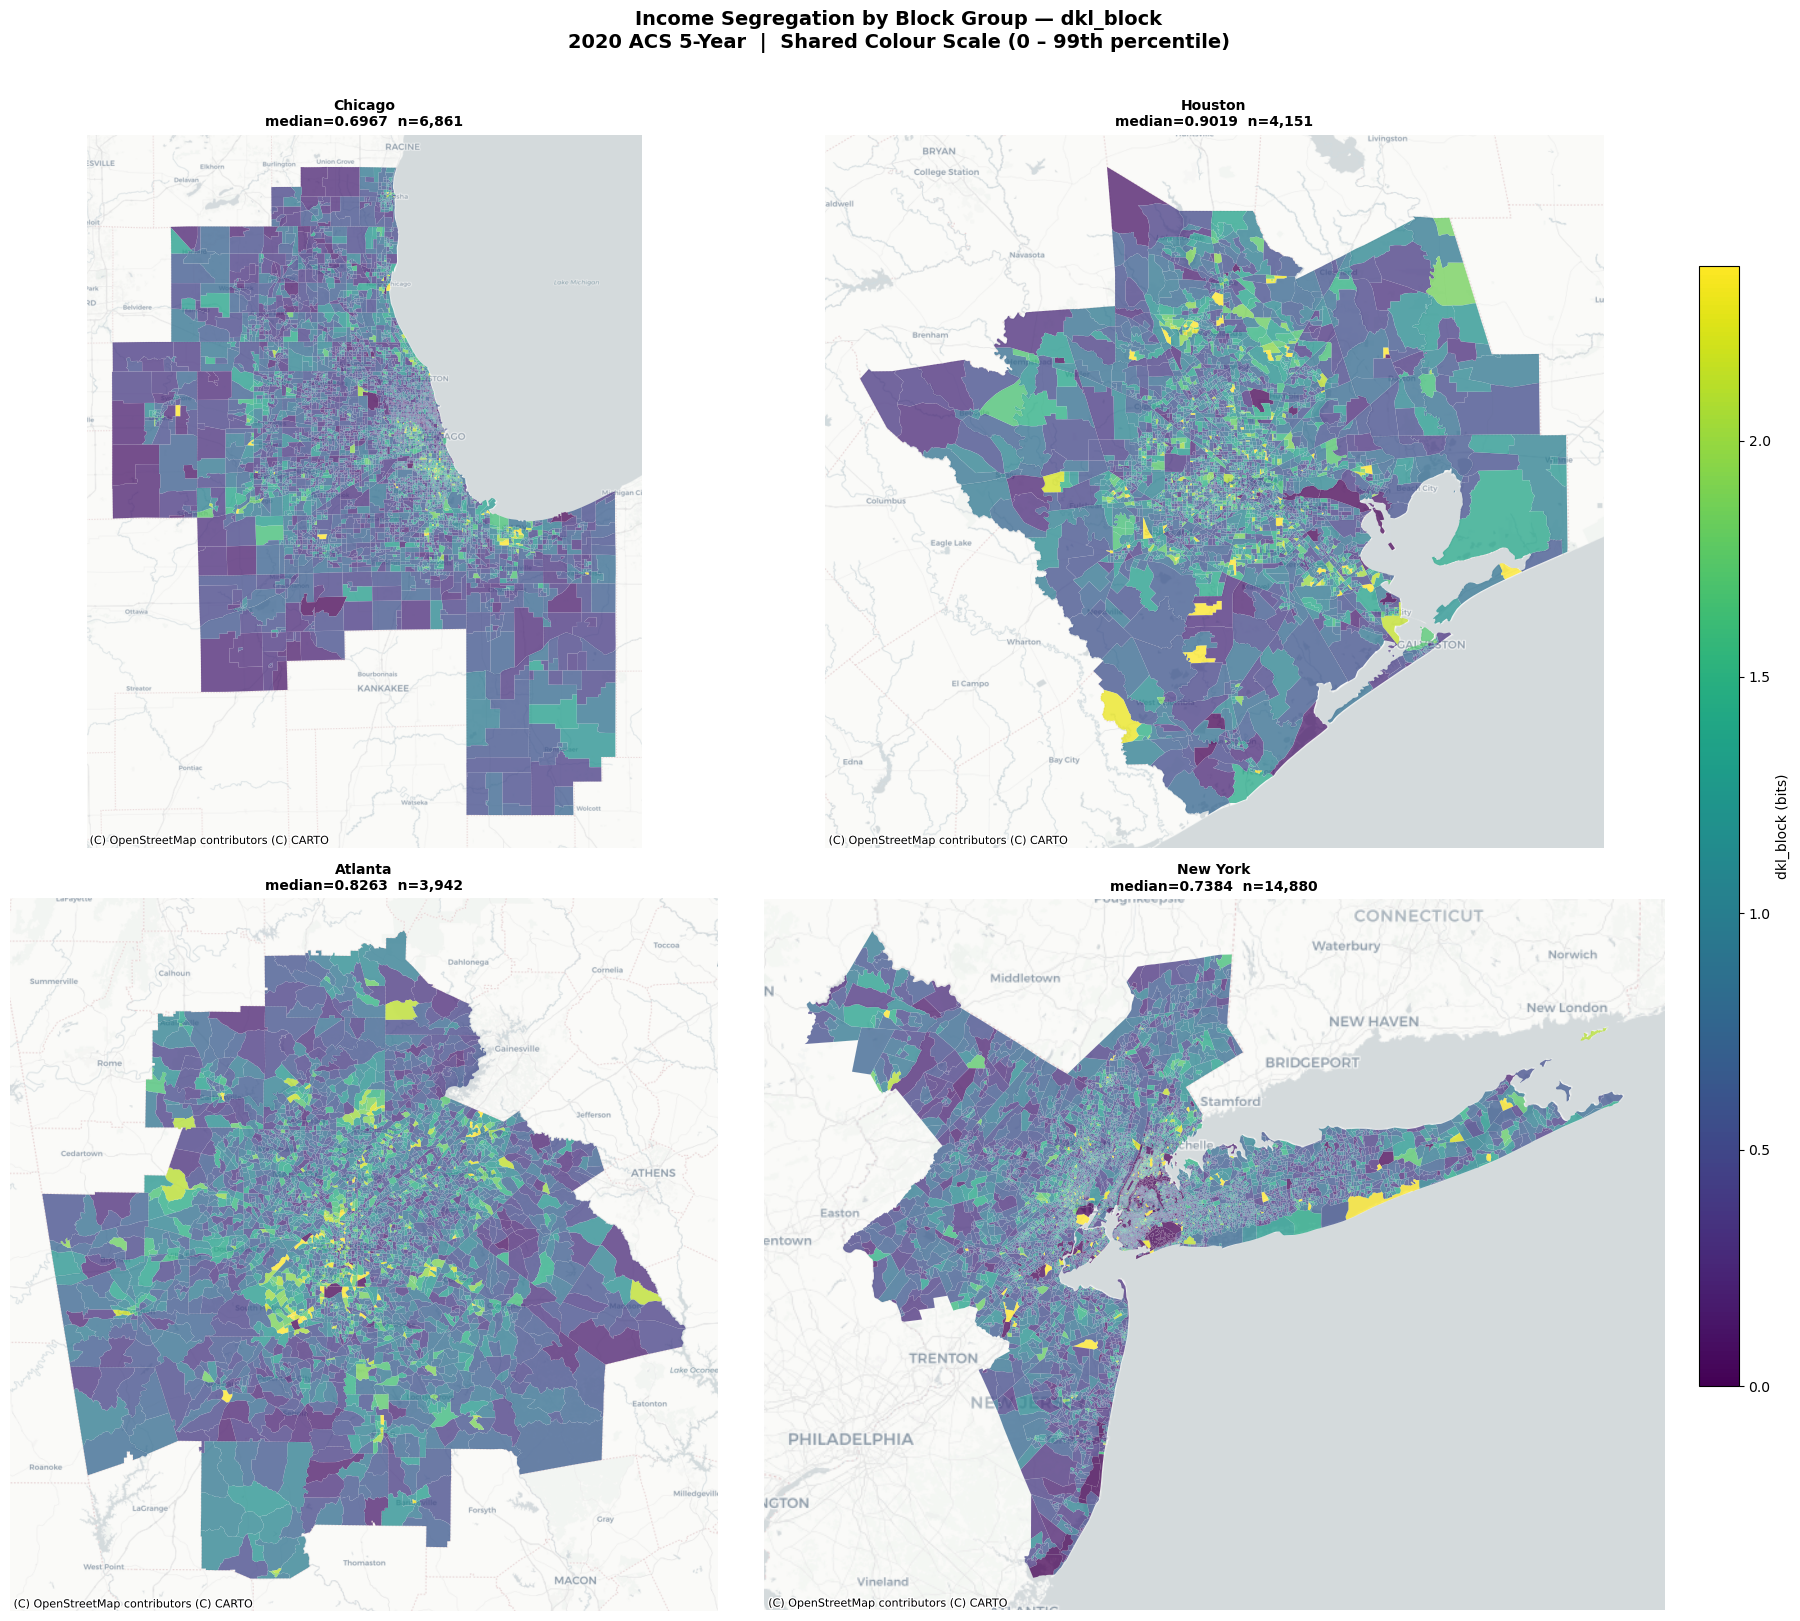

In [8]:
def plot_four_city_panel(city_gdfs: dict, cities: list,
                          vmin: float, vmax: float,
                          cmap: str = 'viridis',
                          figsize: tuple = (20, 16),
                          alpha: float = 0.75) -> None:
    """
    2×2 panel of choropleth maps, one per city, with a shared colourbar.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes_flat = axes.flatten()

    norm = Normalize(vmin=vmin, vmax=vmax)

    for ax, city_full in zip(axes_flat, cities):
        city_gdf = city_gdfs.get(city_full, gpd.GeoDataFrame())
        label    = CITY_SHORT[city_full]

        if city_gdf.empty or city_gdf['dkl_block'].isna().all():
            ax.set_title(f'{label} — no data')
            ax.set_axis_off()
            continue

        missing = city_gdf[city_gdf['dkl_block'].isna()]
        present = city_gdf[city_gdf['dkl_block'].notna()]

        if not missing.empty:
            missing.plot(ax=ax, color='#d9d9d9', linewidth=0, alpha=0.4)

        present.plot(
            column='dkl_block', ax=ax,
            cmap=cmap, vmin=vmin, vmax=vmax,
            linewidth=0.05, edgecolor='white',
            alpha=alpha, legend=False
        )

        if HAS_CONTEXTILY:
            try:
                ctx.add_basemap(
                    ax,
                    source=ctx.providers.CartoDB.Positron,
                    zoom='auto', zorder=0
                )
            except Exception:
                pass

        vals = present['dkl_block']
        ax.set_title(
            f'{label}\n'
            f'median={vals.median():.4f}  n={len(vals):,}',
            fontsize=10, fontweight='bold'
        )
        ax.set_axis_off()

    # Shared colourbar on right side
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    fig.colorbar(sm, cax=cbar_ax, label='dkl_block (bits)')

    fig.suptitle(
        'Income Segregation by Block Group — dkl_block\n'
        '2020 ACS 5-Year  |  Shared Colour Scale (0 – 99th percentile)',
        fontsize=14, fontweight='bold', y=1.01
    )
    plt.tight_layout(rect=[0, 0, 0.89, 1])
    plt.show()


plot_four_city_panel(city_gdfs, CITIES, VMIN, VMAX)


## 7. Distribution of dkl_block per City

Complement the spatial map with a density plot of the `dkl_block` distribution
for each city, with the median marked.


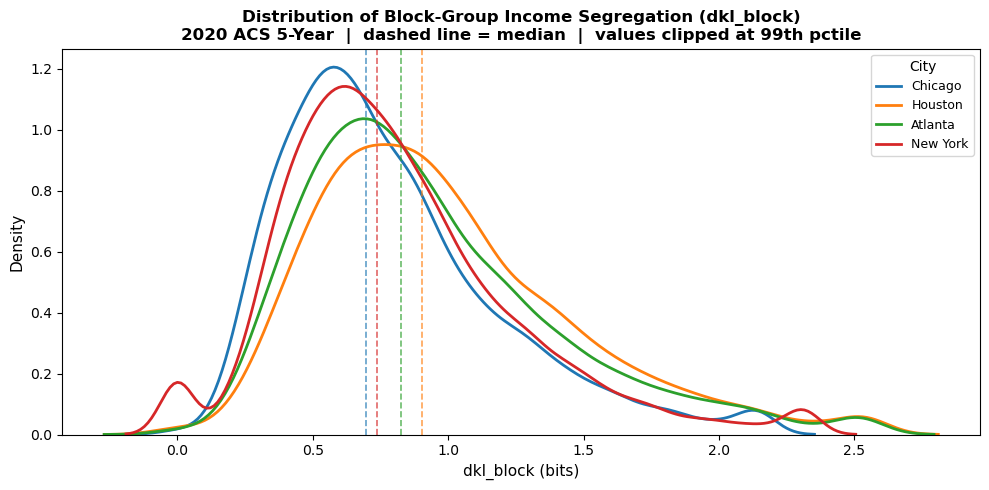

In [9]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))

palette = sns.color_palette('tab10', len(CITIES))

for color, city_full in zip(palette, CITIES):
    label = CITY_SHORT[city_full]
    gdf   = city_gdfs.get(city_full, gpd.GeoDataFrame())
    if gdf.empty:
        continue
    vals = gdf['dkl_block'].dropna()
    if vals.empty:
        continue
    # Clip at 99th percentile for readability
    clip = float(vals.quantile(0.99))
    vals_clipped = vals.clip(upper=clip)

    sns.kdeplot(vals_clipped, ax=ax, label=label, color=color, linewidth=2)
    ax.axvline(vals.median(), color=color, linestyle='--', linewidth=1.2, alpha=0.7)

ax.set_xlabel('dkl_block (bits)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title(
    'Distribution of Block-Group Income Segregation (dkl_block)\n'
    '2020 ACS 5-Year  |  dashed line = median  |  values clipped at 99th pctile',
    fontsize=12, fontweight='bold'
)
ax.legend(title='City', fontsize=9)
plt.tight_layout()
plt.show()


## 8. High-Segregation Block Groups — Top 5% Map

Highlight only the block groups in the top 5% of `dkl_block` for each city.
These are the most income-segregated neighbourhoods in each metro area.


Plotting high-segregation map: Chicago …


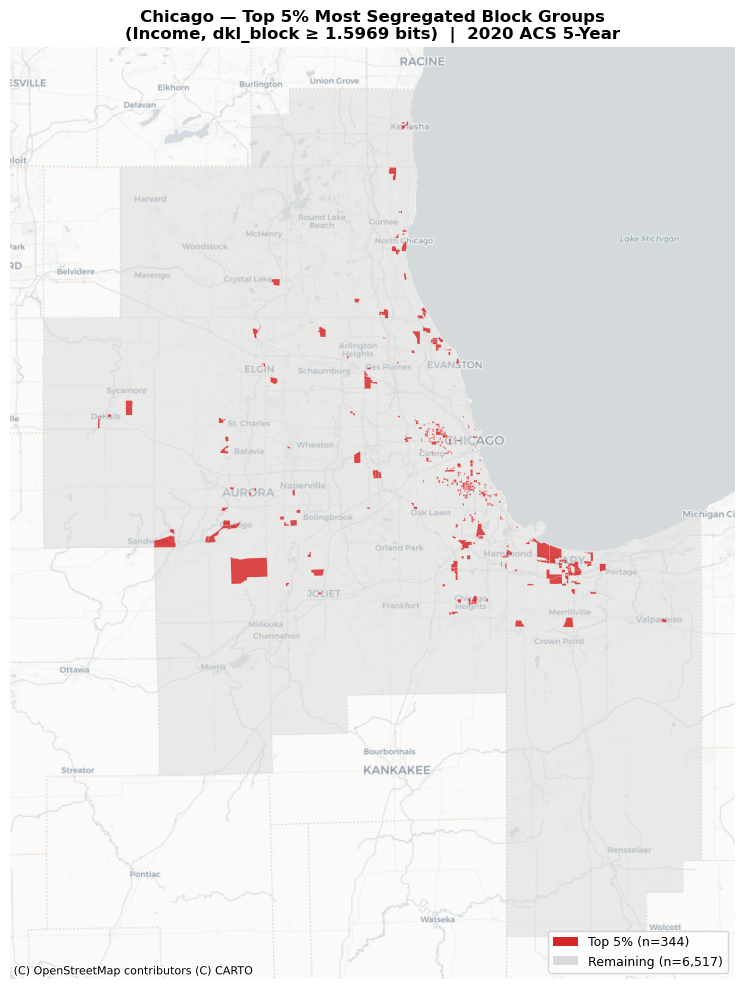

Plotting high-segregation map: Houston …


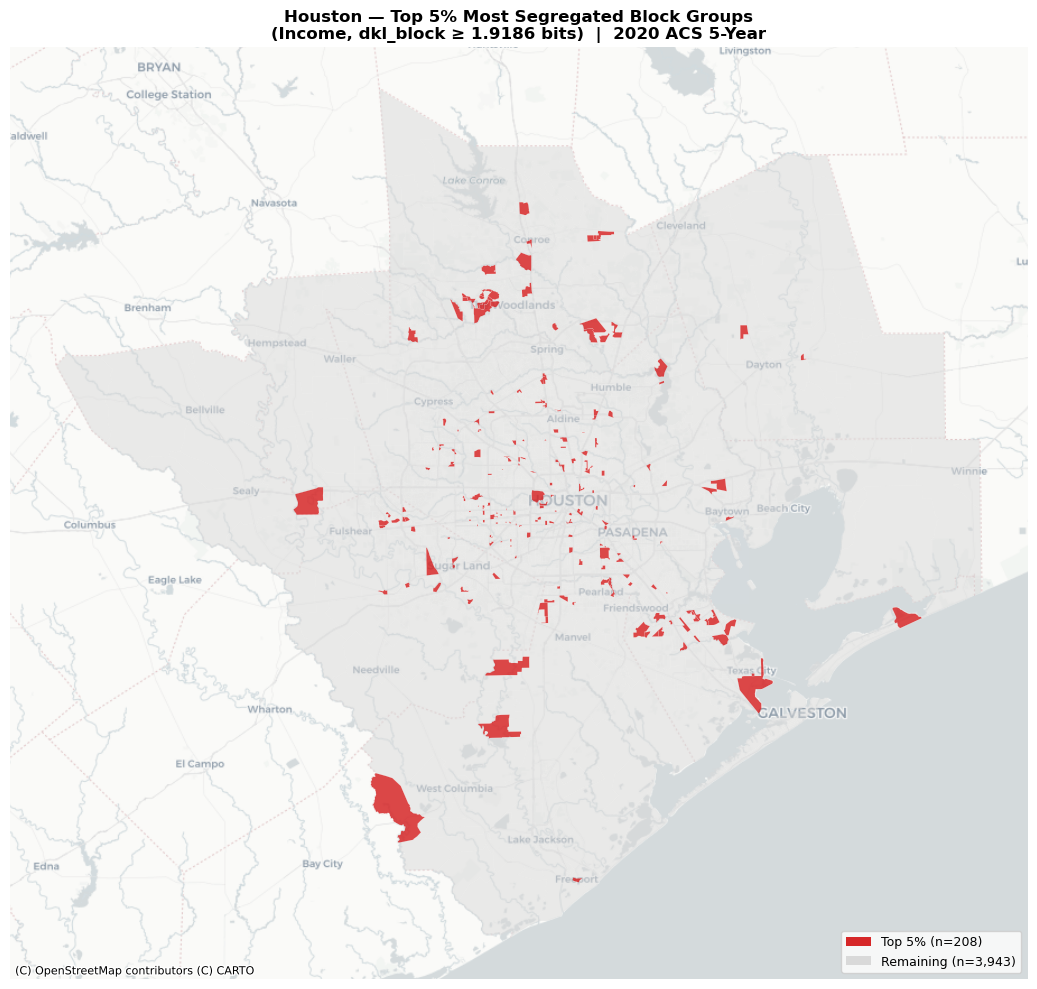

Plotting high-segregation map: Atlanta …


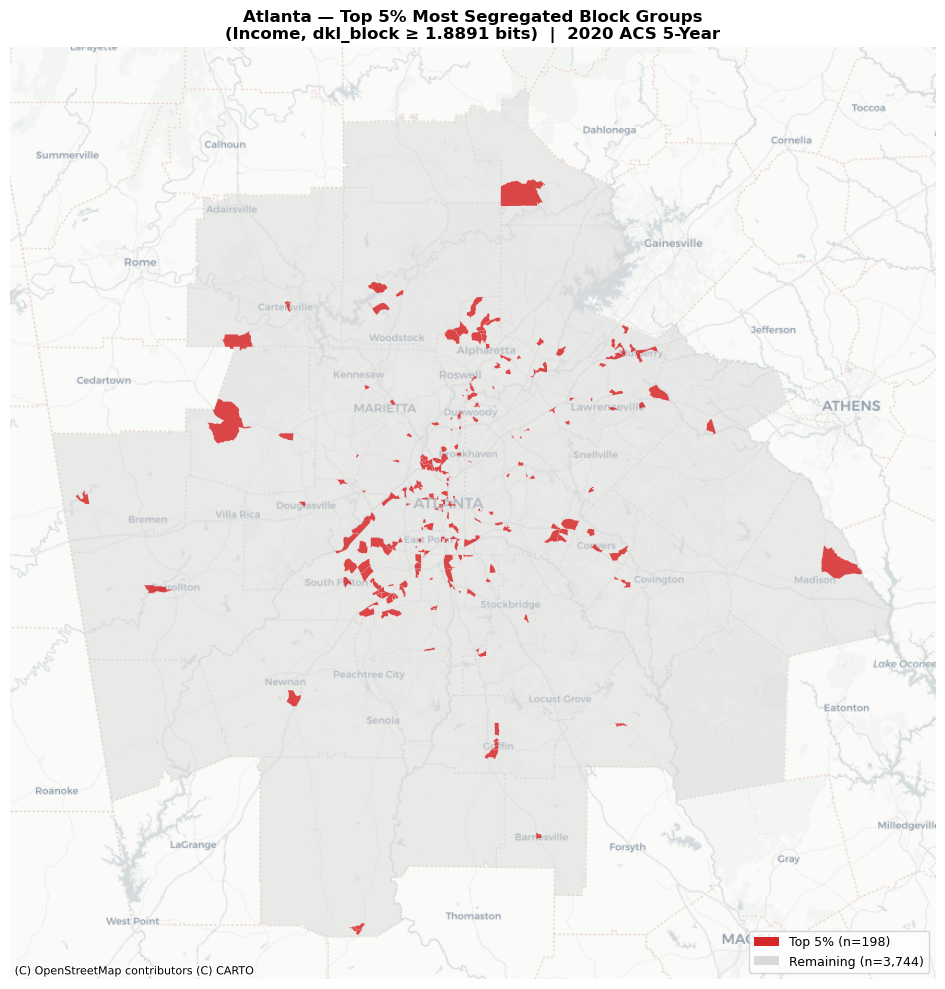

Plotting high-segregation map: New York …


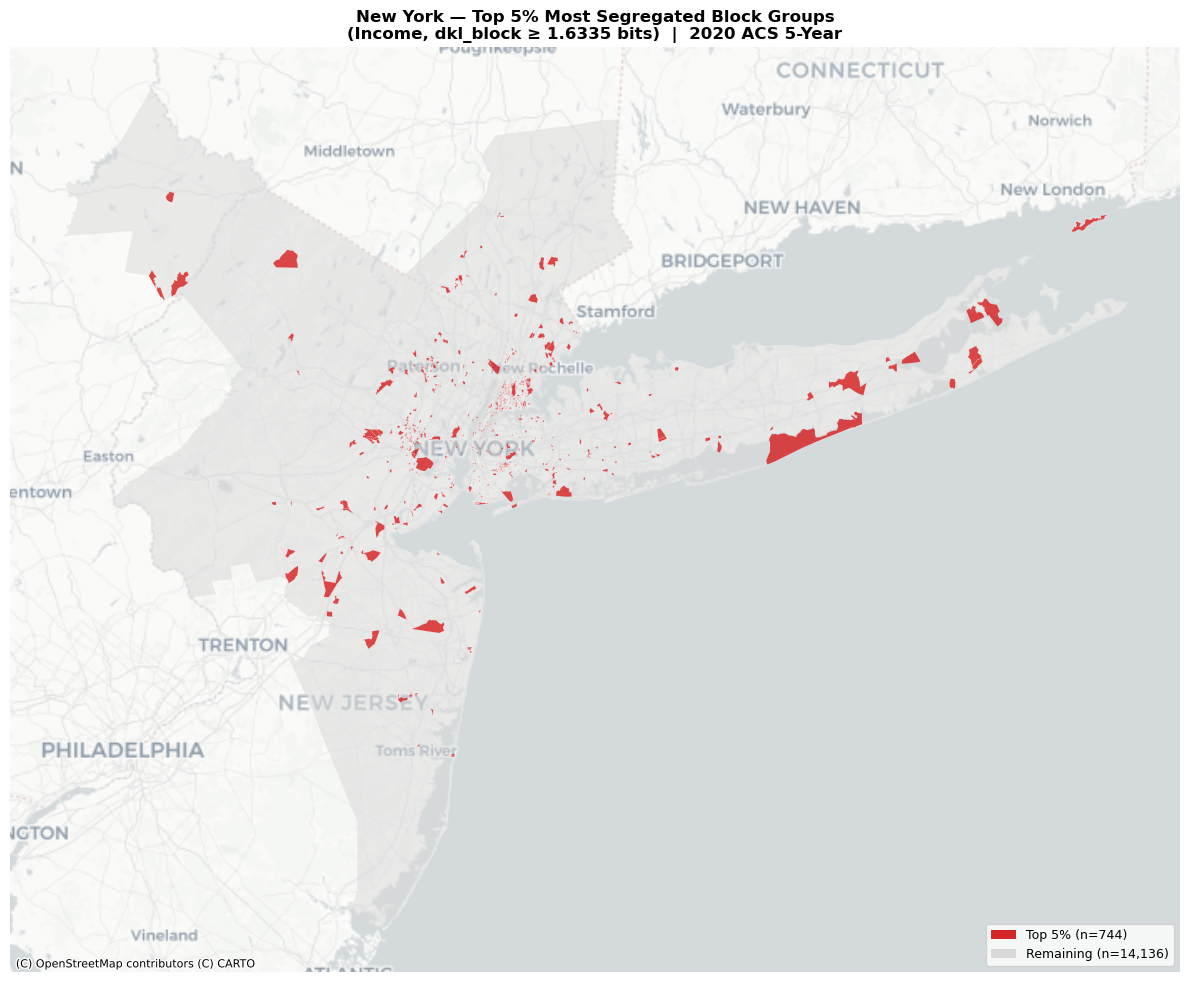

In [10]:
def plot_top_segregated(city_gdf: gpd.GeoDataFrame, city_label: str,
                         pctile: float = 0.95, figsize: tuple = (12, 10)) -> None:
    """
    Map where top `pctile` block groups are highlighted in red; rest in light grey.
    """
    if city_gdf.empty:
        return

    present = city_gdf[city_gdf['dkl_block'].notna()].copy()
    threshold = present['dkl_block'].quantile(pctile)
    top       = present[present['dkl_block'] >= threshold]
    rest      = present[present['dkl_block'] <  threshold]

    fig, ax = plt.subplots(figsize=figsize)

    rest.plot(ax=ax, color='#d9d9d9', linewidth=0, alpha=0.5, zorder=1,
              label='Below threshold')
    top.plot( ax=ax, color='#d62728', linewidth=0.1, edgecolor='white',
              alpha=0.85, zorder=2, label=f'Top {int((1-pctile)*100)}%')

    if HAS_CONTEXTILY:
        try:
            ctx.add_basemap(
                ax,
                source=ctx.providers.CartoDB.Positron,
                zoom='auto', zorder=0
            )
        except Exception:
            pass

    ax.set_title(
        f'{city_label} — Top {int((1-pctile)*100)}% Most Segregated Block Groups\n'
        f'(Income, dkl_block ≥ {threshold:.4f} bits)  |  2020 ACS 5-Year',
        fontsize=12, fontweight='bold'
    )
    ax.set_axis_off()

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#d62728', label=f'Top {int((1-pctile)*100)}% (n={len(top):,})'),
        Patch(facecolor='#d9d9d9', label=f'Remaining (n={len(rest):,})'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

    plt.tight_layout()
    plt.show()


for city_full in CITIES:
    label = CITY_SHORT[city_full]
    print(f'Plotting high-segregation map: {label} …')
    plot_top_segregated(city_gdfs[city_full], label)


In [11]:
# Summary statistics table across all four cities
rows = []
for city_full in CITIES:
    label = CITY_SHORT[city_full]
    gdf = city_gdfs.get(city_full, gpd.GeoDataFrame())
    if gdf.empty:
        continue
    vals = gdf['dkl_block'].dropna()
    rows.append({
        'city'       : label,
        'n_blocks'   : len(vals),
        'mean'       : vals.mean(),
        'median'     : vals.median(),
        'std'        : vals.std(),
        'p25'        : vals.quantile(0.25),
        'p75'        : vals.quantile(0.75),
        'p95'        : vals.quantile(0.95),
        'max'        : vals.max(),
    })

summary = pd.DataFrame(rows).set_index('city').round(5)
summary


n_blocks     mean   median      std      p25      p75      p95  \
city                                                                       
Chicago       6861  0.78760  0.69670  0.42071  0.49191  0.98558  1.59688   
Houston       4151  0.98731  0.90185  0.48921  0.63714  1.24042  1.91863   
Atlanta       3942  0.93306  0.82629  0.49184  0.58914  1.17457  1.88911   
New York     14880  0.81935  0.73842  0.46915  0.51876  1.02571  1.63352   

              max  
city               
Chicago   3.88429  
Houston   3.75812  
Atlanta   4.68647  
New York  5.03545